# 1. Modules

## 1.1. Load basics

In [48]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2. Load library modules

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.transformation.MagneticFields import MagneticFields 

from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [50]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = 1e-4*(np.rot90(Bx))
B[1, :, :] = 1e-4*(np.rot90(By))
B[2, :, :] = 1e-4*(np.rot90(Bz))
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
# dataset.plot_target()

Applied a high frequency filter, removing all components smaller than 0.1 um


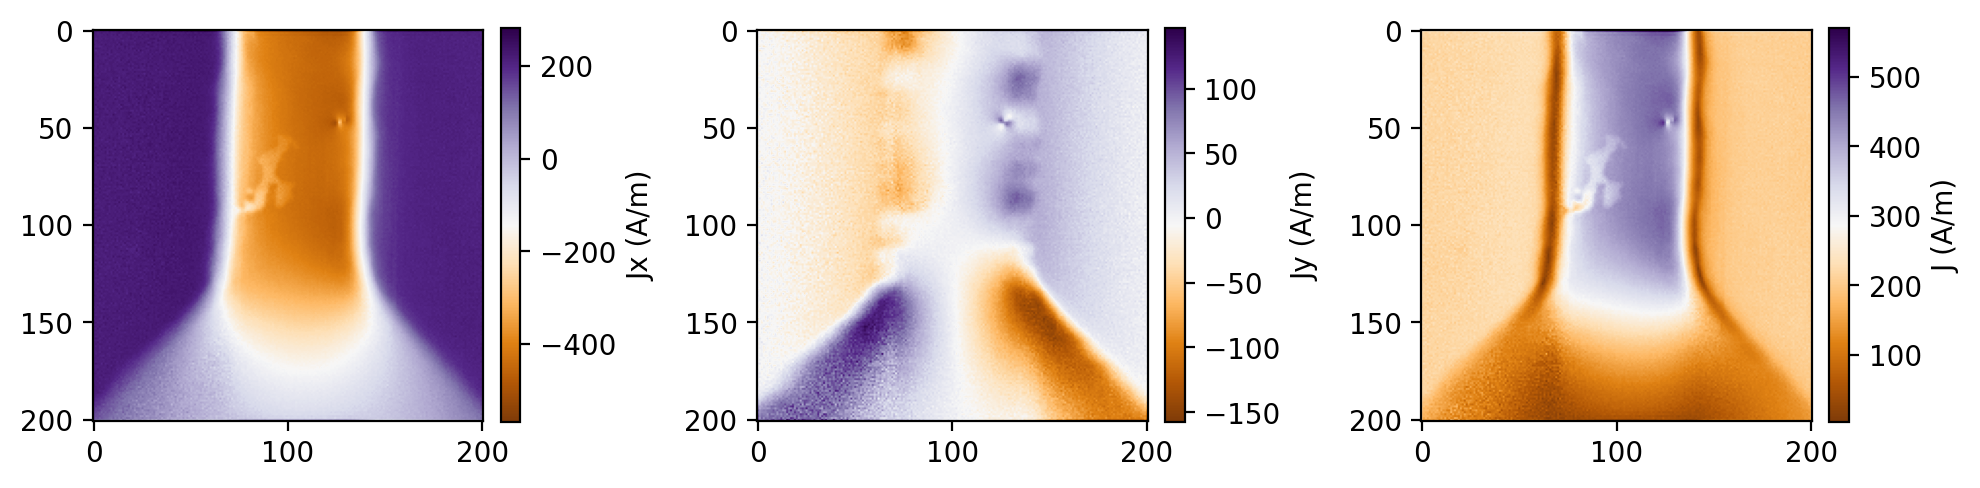

In [83]:
dataset2 = copy.deepcopy(dataset)
dataset2.set_transformer(Bxyz2Jxy)
dataset2.transform_data()

J = torch.sqrt(dataset2.transformed_target[0,...]**2 + dataset2.transformed_target[1,...]**2)

FJx = -1*dataset2.transformed_target[0,...]
FJy = -1*dataset2.transformed_target[1,...]
FJ = -1*J

# set the figure size
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow((FJx),  cmap='PuOr')
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Jx (A/m)')

plt.subplot(1,3,2)
plt.imshow(FJy, cmap='PuOr')
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('Jy (A/m)')

plt.subplot(1,3,3)
plt.imshow(J, cmap='PuOr')
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')

plt.tight_layout()

In [52]:
# check the actions that have been applied to the dataset
dataset.actions

action type  reverseable reverse action  \
0             load_data        False           None   
1  remove_DC_background        False           None   

                               description parameters  
0                          loaded the data       None  
1  Removed the DC background from the data       None

## Reconstruct the current density using a neural network using Bz data

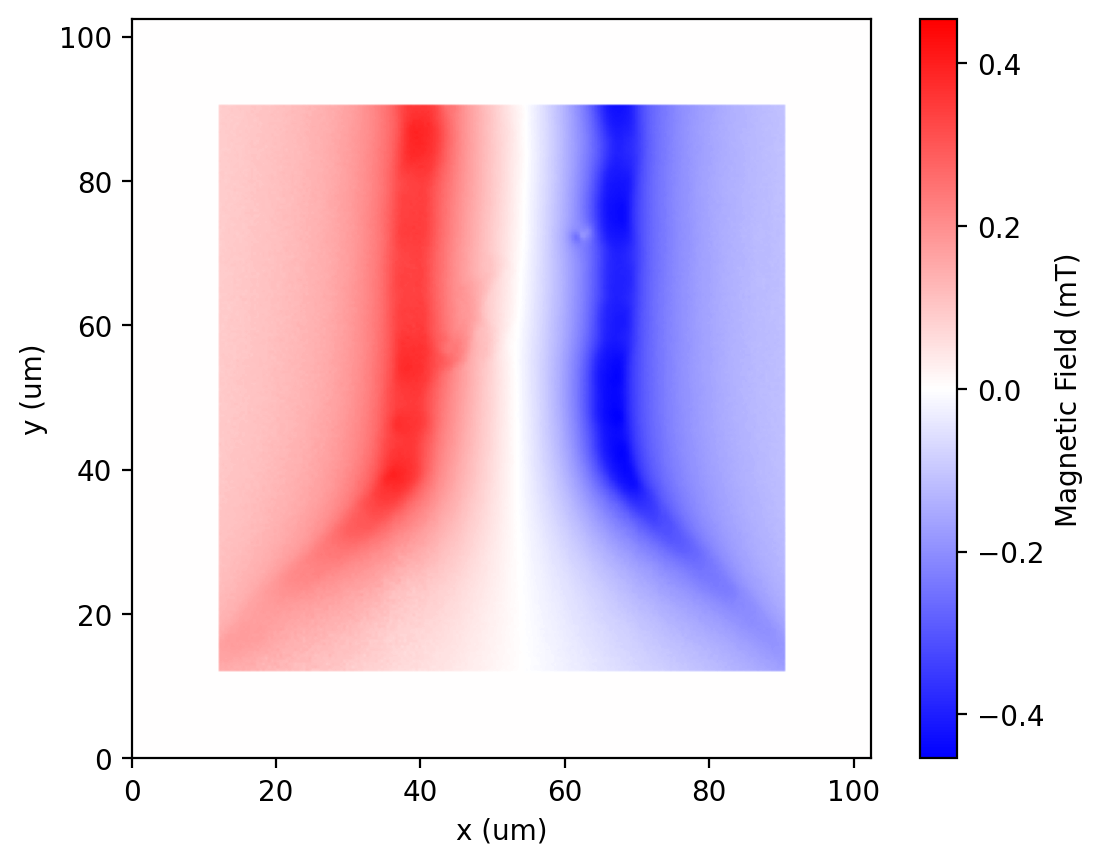

In [53]:
from magrec.method.FCNN import FCNN
from magrec.method.CNN import CNN
from magrec.models.Jxy import Jxy

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0

dataset2 = Data()
dataset2.load_data(
       B[2, :, :]  , 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset2.remove_DC_background()
dataset2.add_hanning_filter(0.1)
dataset2.crop_data((2,198,2,198))
# dataset.pad_reflective2d()
dataset2.pad_data_to_power_of_two()
dataset2.plot_target()

In [54]:
dataset2.actions

action type  reverseable reverse action  \
0             load_data        False           None   
1  remove_DC_background        False           None   
2        hanning_filter        False           None   
3             crop_data        False      crop_data   
4              pad_data         True      crop_data   

                                         description            parameters  
0                                    loaded the data                  None  
1            Removed the DC background from the data                  None  
2  Applied a low frequency filter, removing all c...      wavelength = 0.1  
3    crop the data with the given region of interest  roi = [2,198,2,198,]  
4  Padded the data to a square image with dimensi...                  None

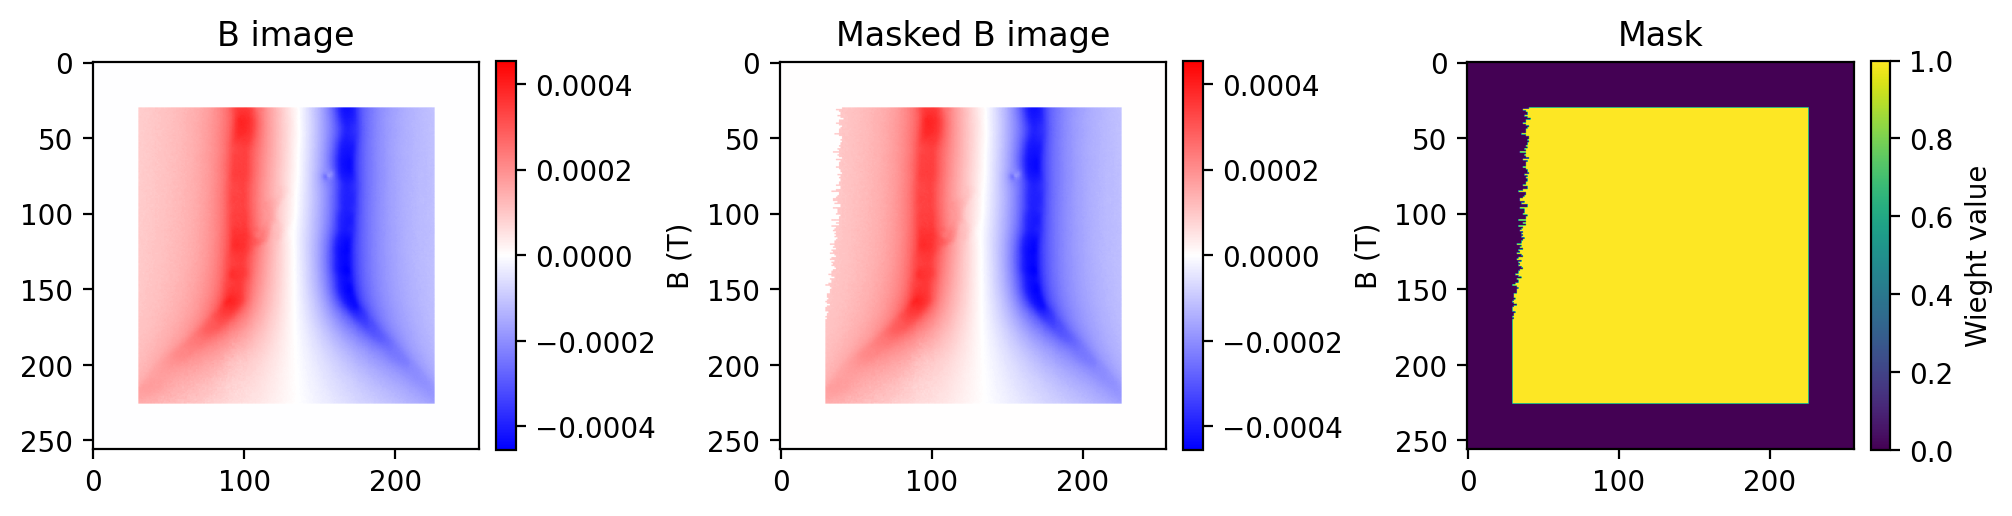

In [55]:
import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_hor_dir(dataset2.target, 0.0001,  plot=True)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1

In [67]:
from magrec.models.Jxy import Jxy 
# Define the model and method
Model = Jxy(dataset2, scaling_factor=1e6,)
FittingMethod = CNN(Model)

Number of sources: 2
Number of targets: 1


In [77]:
FittingMethod.fit(n_epochs=200)

epoch     1 | loss on last mini-batch:  1.94e+04
epoch    11 | loss on last mini-batch:  1.88e+04
epoch    21 | loss on last mini-batch:  1.82e+04
epoch    31 | loss on last mini-batch:  1.75e+04
epoch    41 | loss on last mini-batch:  1.67e+04
epoch    51 | loss on last mini-batch:  1.59e+04
epoch    61 | loss on last mini-batch:  1.51e+04
epoch    71 | loss on last mini-batch:  1.43e+04
epoch    81 | loss on last mini-batch:  1.34e+04
epoch    91 | loss on last mini-batch:  1.25e+04
epoch   101 | loss on last mini-batch:  1.16e+04
epoch   111 | loss on last mini-batch:  1.07e+04
epoch   121 | loss on last mini-batch:  9.76e+03
epoch   131 | loss on last mini-batch:  8.87e+03
epoch   141 | loss on last mini-batch:  8.01e+03
epoch   151 | loss on last mini-batch:  7.19e+03
epoch   161 | loss on last mini-batch:  6.41e+03
epoch   171 | loss on last mini-batch:  5.67e+03
epoch   181 | loss on last mini-batch:  4.98e+03
epoch   191 | loss on last mini-batch:  4.35e+03


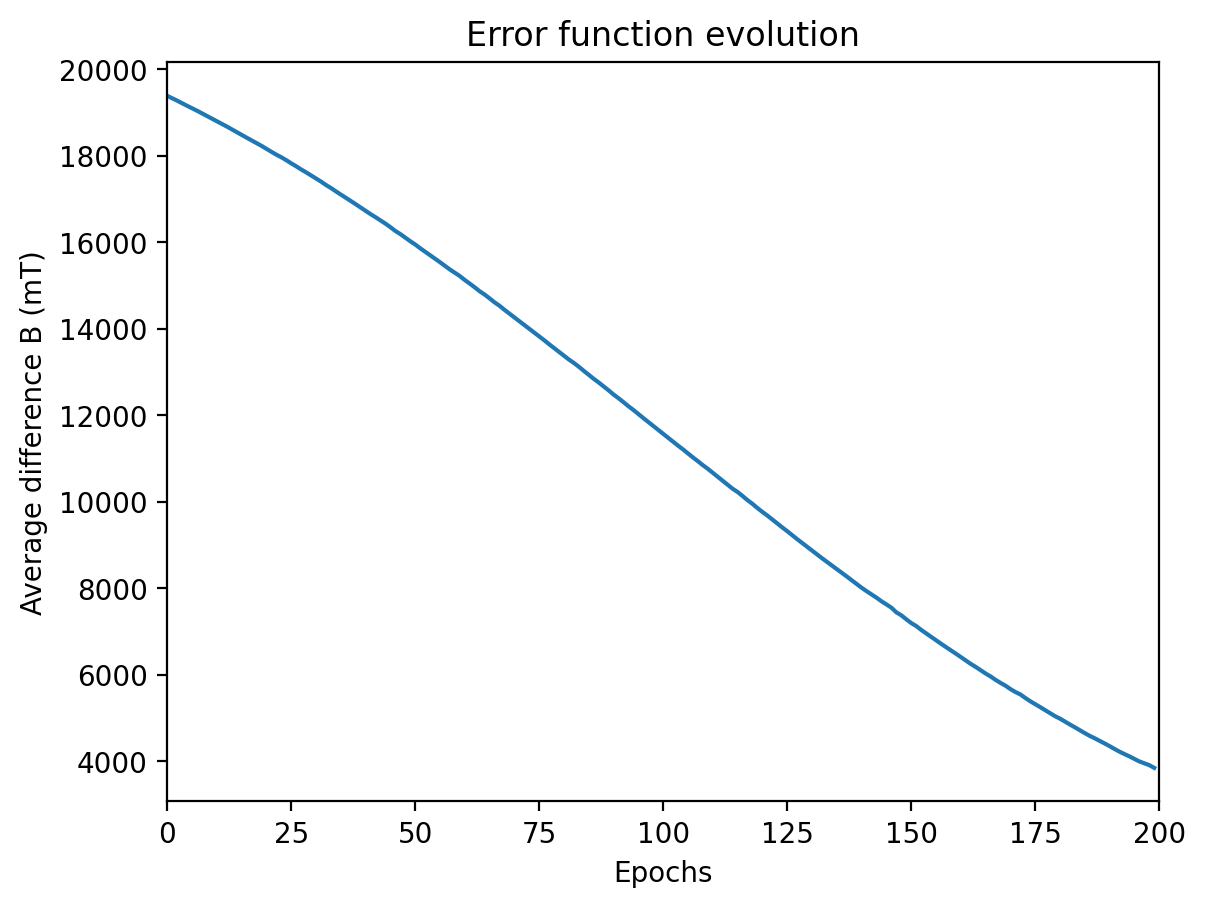

In [78]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


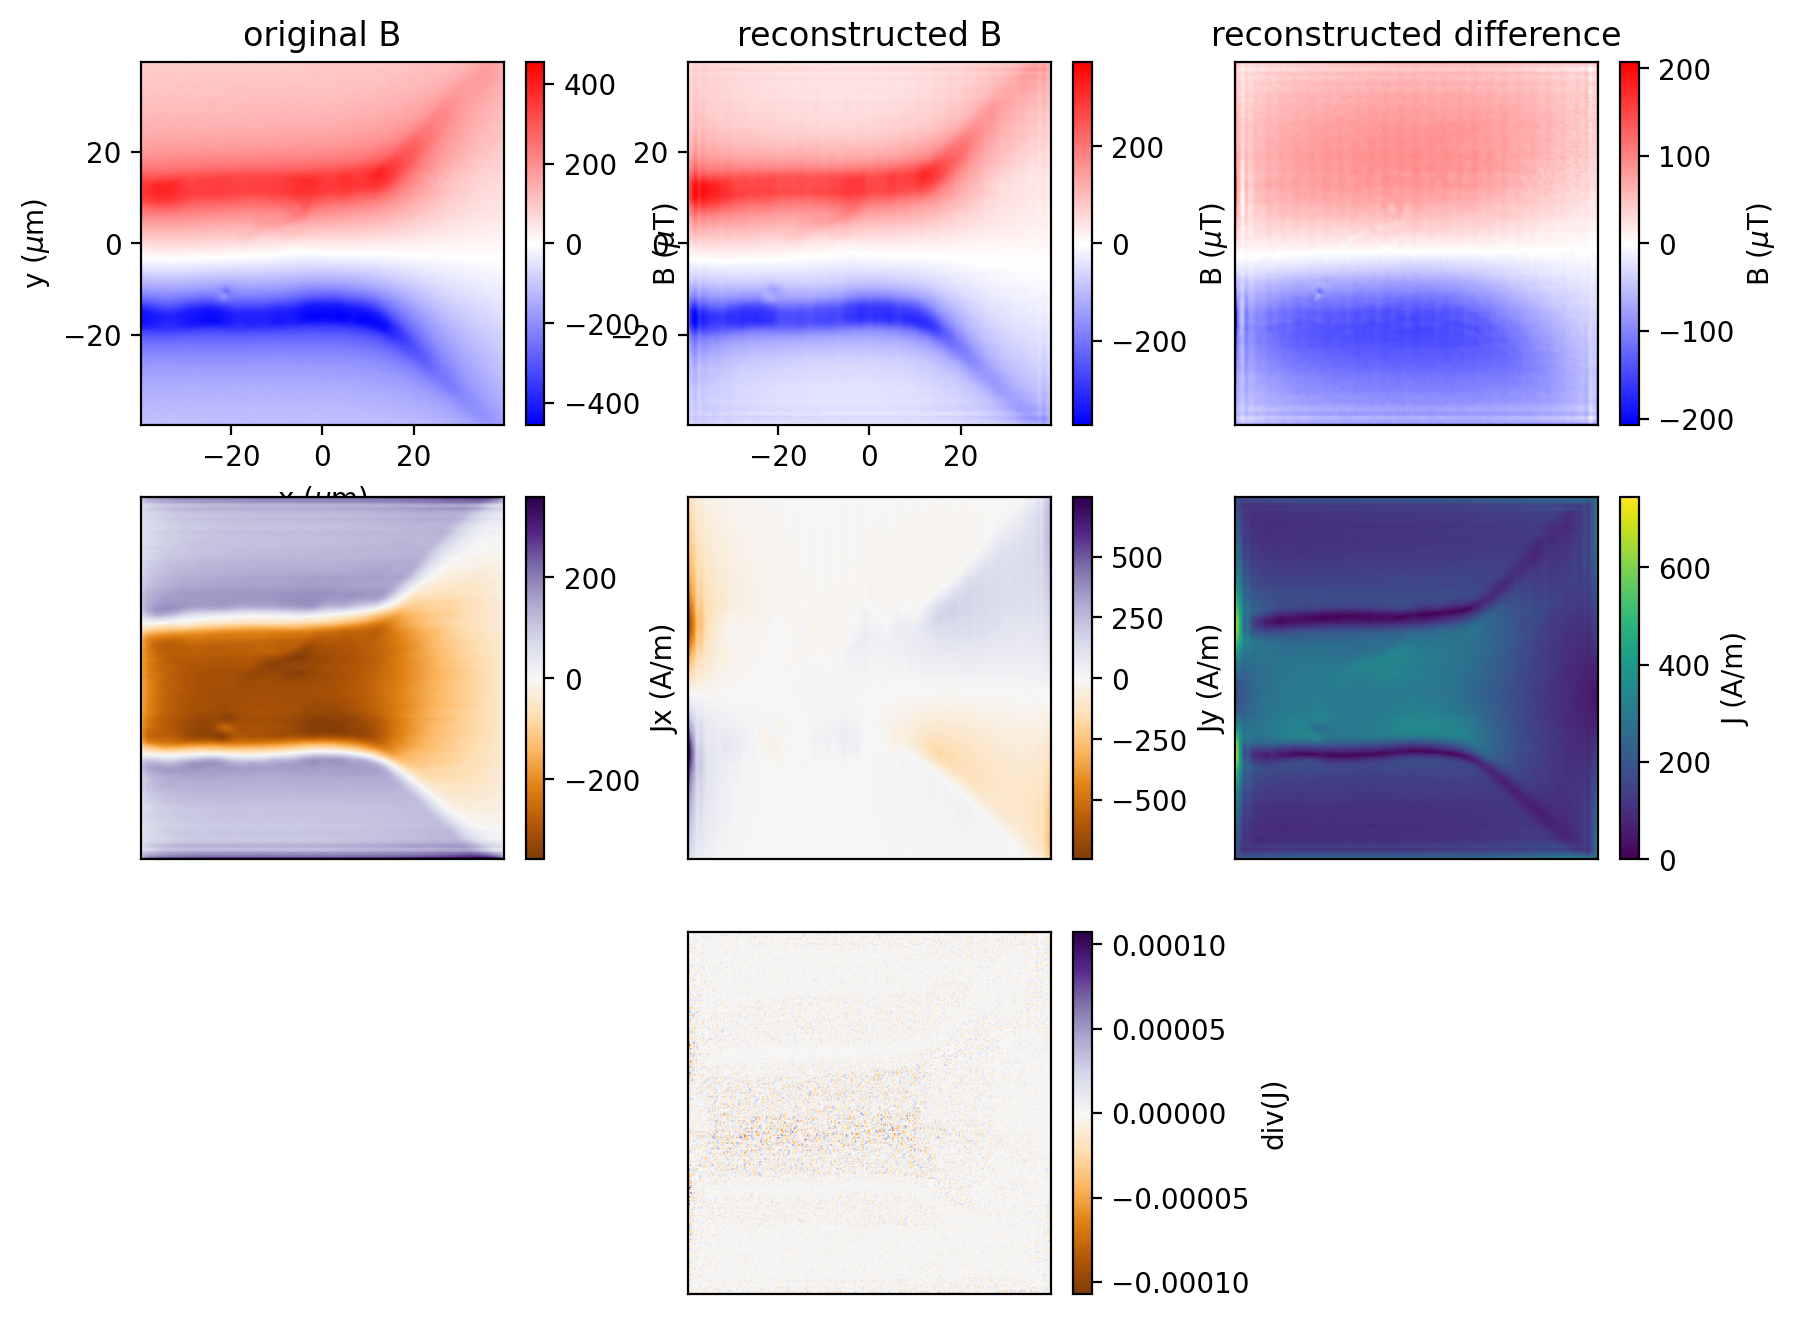

In [79]:
FittingMethod.extract_results(remove_padding=True)
FittingMethod.plot_results()

# FCNN method

In [71]:
from magrec.models.Jxy import Jxy 
from magrec.method.FCNN import FCNN
# Define the model and method
Model_2 = Jxy(dataset2,
            scaling_factor = 1e6,
            spatial_filter = False,
            spatial_filter_type = "Gaussian",
            spatial_filter_width = [0.4, 0.4])
FittingMethodFCNN = FCNN(Model_2, learning_rate=0.1)

Number of sources: 2
Number of targets: 1


In [72]:
FittingMethodFCNN.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  2.21e+04
epoch    26 | loss on last mini-batch:  2.20e+04
epoch    51 | loss on last mini-batch:  5.22e+03
epoch    76 | loss on last mini-batch:  1.08e+03


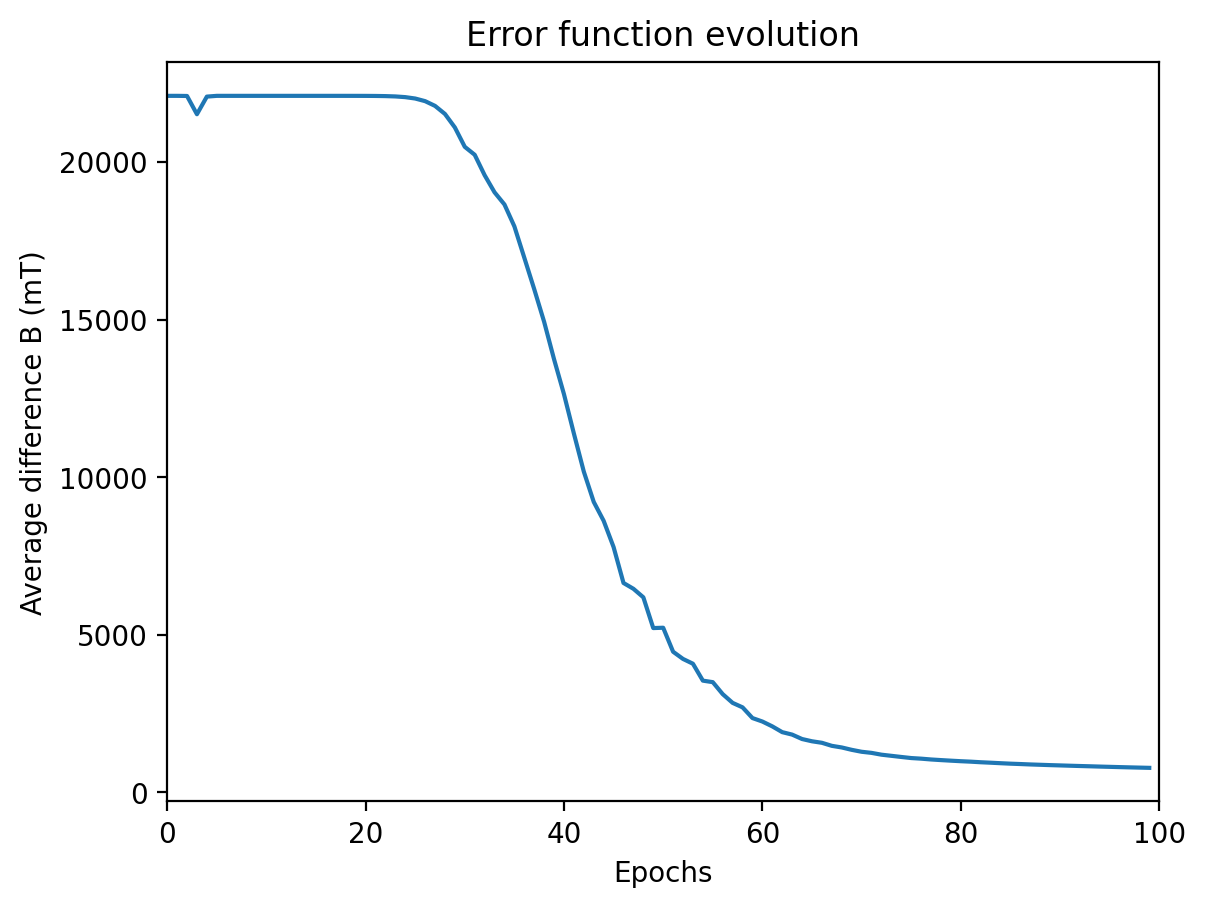

In [73]:
FittingMethodFCNN.plot_loss()

Removed the padding that was applied to the data


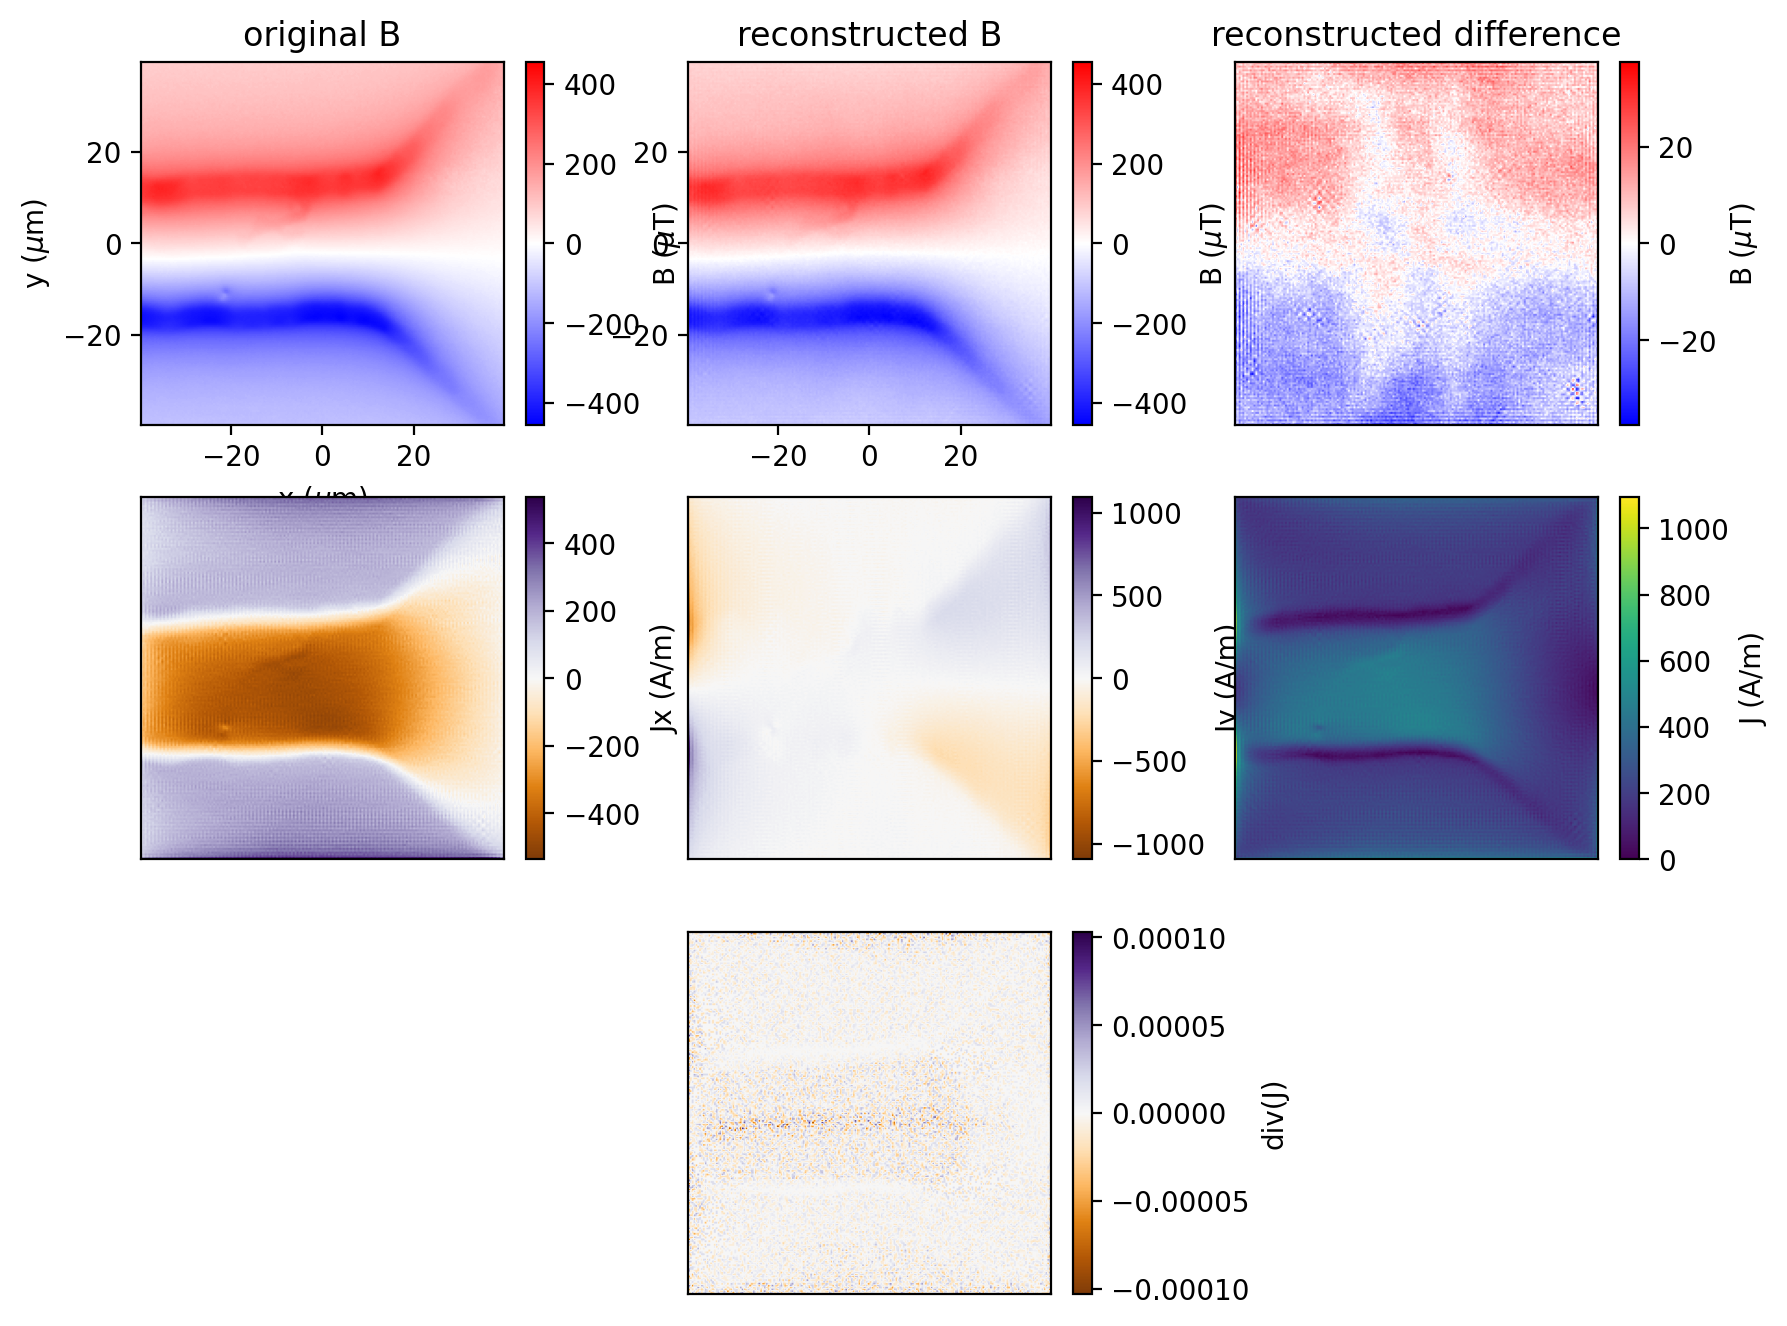

In [74]:
FittingMethodFCNN.extract_results(remove_padding=True)
FittingMethodFCNN.plot_results()

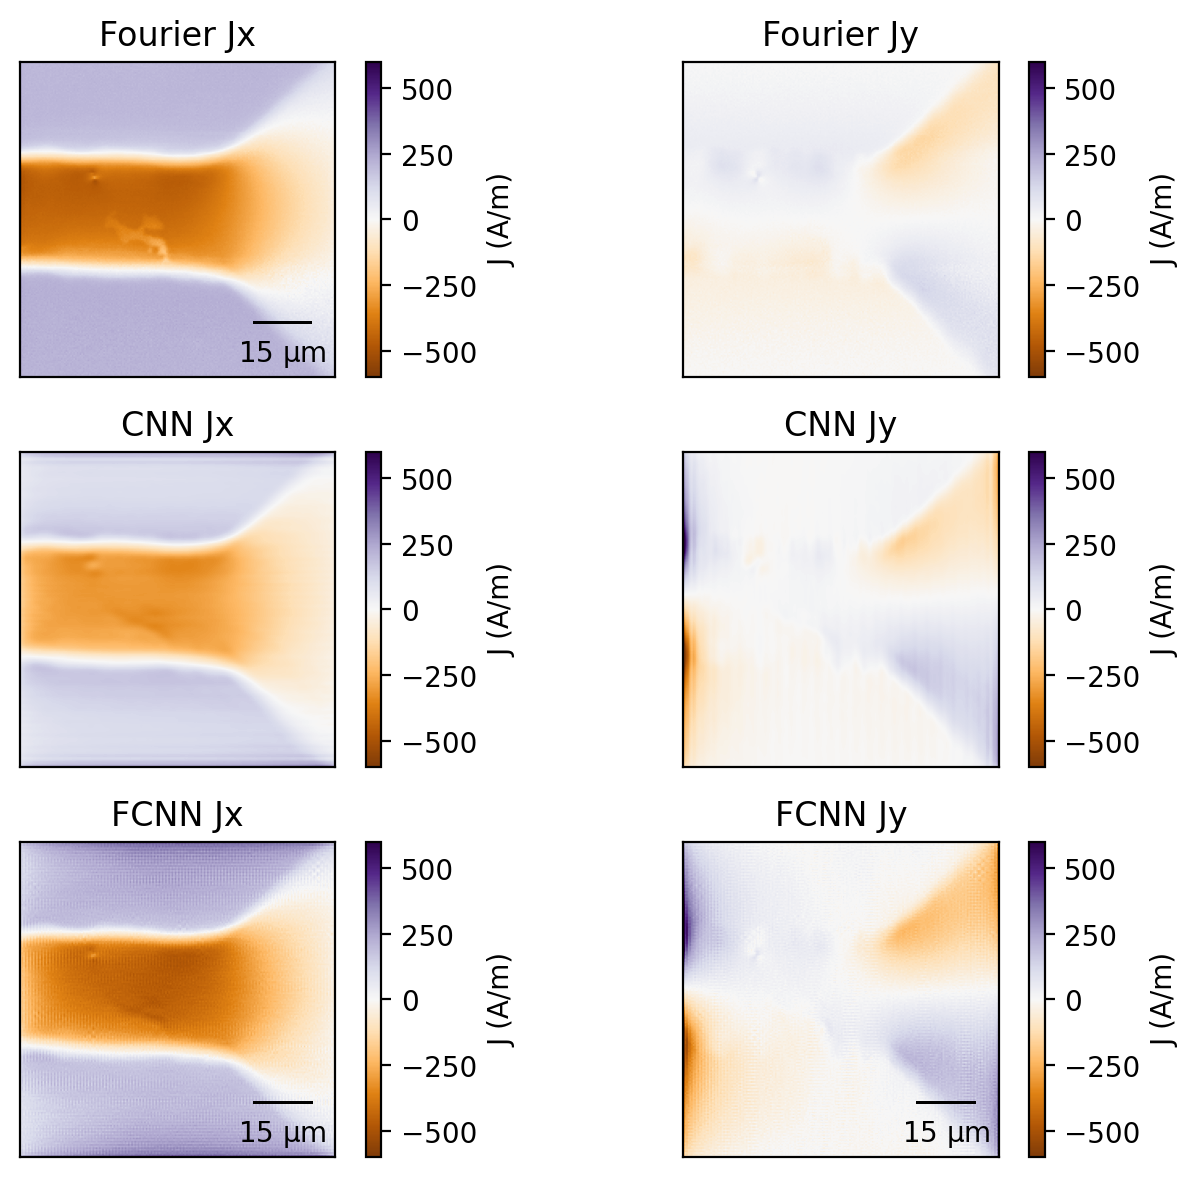

In [87]:
# plot the comarison between the three methods

# Sompare the results of all the different reconstructions
from matplotlib_scalebar.scalebar import ScaleBar

plt.figure(figsize=(8, 6))
plt.subplot(3,2,1)
plt.imshow(np.rot90(FJx), cmap="PuOr", vmin=-600, vmax=600)
plt.title("Fourier Jx")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')
# add a scale bar
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False) 
plt.gca().add_artist(scalebar)

plt.subplot(3,2,2)
plt.imshow(np.rot90(FJy), cmap="PuOr", vmin=-600, vmax=600)
plt.title("Fourier Jy") 
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')

plt.subplot(3,2,3)
plt.imshow(np.rot90(FittingMethod.results["Jx"]), cmap="PuOr", vmin=-600, vmax=600)
plt.title("CNN Jx")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')

plt.subplot(3,2,4)
plt.imshow(np.rot90(FittingMethod.results["Jy"]), cmap="PuOr", vmin=-600, vmax=600)
plt.title("CNN Jy")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')

plt.subplot(3,2,5)
plt.imshow(np.rot90(FittingMethodFCNN.results["Jx"]), cmap="PuOr", vmin=-600, vmax=600)
plt.title("FCNN Jx")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')
# add a scale bar
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False)
plt.gca().add_artist(scalebar)

plt.subplot(3,2,6)
plt.imshow(np.rot90(FittingMethodFCNN.results["Jy"]), cmap="PuOr", vmin=-600, vmax=600)
plt.title("FCNN Jy")
plt.xticks([])
plt.yticks([])
# make the colour bar the same size as the image
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('J (A/m)')
# add a scale bar
scalebar = ScaleBar(dx, units="um", location = "lower right", frameon=False)
plt.gca().add_artist(scalebar)

plt.tight_layout()